*Теоретический материал:* https://youtu.be/Z_eB3KO_XA4?t=1765

#Прогнозирование акций Лукойл

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=3740

In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/My Drive/Базы/акции лукойл/18_19.csv', sep=';')

In [ ]:
#Выводим пять первых строк
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
#Выцепялем numpy значения .values
#И выводим нулевой
txt = base_data.values[0]
print(txt)

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [ ]:
base_data16 = pd.read_csv('/content/drive/My Drive/Базы/акции лукойл/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/Базы/акции лукойл/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data16_17.shape[0]

263925

In [ ]:
# Выводим параметры одного файла
d = data18_19
print(len(d)) # Сколько есть записей
print(len(d.iloc[0])) # Длина одной строки данных
print(d.iloc[0]) # Пример первой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
# Объединяем базы из двух файлов
data = data16_17.copy()                 # Создаем копию первой базы
data = pd.concat([data16_17,data18_19]) # Присоединяем к ней вторую базу
data = np.array(data)                   # Превращаем в numpy массив

In [ ]:
# Сравниваем размеры
print(len(data16_17)) # Выводим размер первой базы
print(len(data18_19)) # Выводим размер второй базы
print(len(data))      # Выводим размер суммарной базы

263925
217947
481872


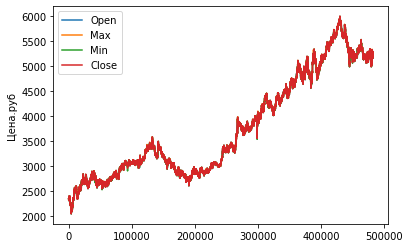

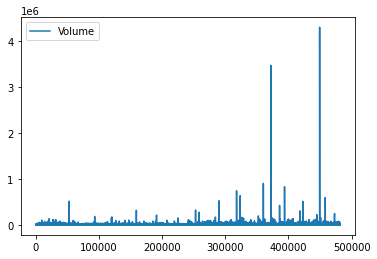

In [ ]:
#Отображаем исходные от точки start и длинной step
start = 0            #С какой точки начинаем
step = data.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+step,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+step,4], label="Volume")
plt.legend()
plt.show()

**Функция загрузки данных**

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=4016

In [ ]:
#Формируем параметры загрузки данных

xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [ ]:
yTrain[0]

array([0.07810564])

In [ ]:
xTrain[0]

array([0.07839171, 0.07822035, 0.07839814, 0.07810564, 0.00059283])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 1)


## Полносвязная сеть

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=4540

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
22579/22579 [==============================] - 41s 2ms/step - loss: 0.0027 - val_loss: 1.2994e-04
Epoch 2/20
22579/22579 [==============================] - 41s 2ms/step - loss: 2.2360e-04 - val_loss: 4.0450e-05
Epoch 3/20
22579/22579 [==============================] - 41s 2ms/step - loss: 7.0468e-05 - val_loss: 5.0537e-05
Epoch 4/20
22579/22579 [==============================] - 41s 2ms/step - loss: 4.1487e-05 - val_loss: 2.0353e-05
Epoch 5/20
22579/22579 [==============================] - 41s 2ms/step - loss: 2.8939e-05 - val_loss: 7.2116e-06
Epoch 6/20
22579/22579 [==============================] - 42s 2ms/step - loss: 1.8962e-05 - val_loss: 6.4599e-06
Epoch 7/20
22579/22579 [==============================] - 41s 2ms/step - loss: 1.5563e-05 - val_loss: 1.2443e-05
Epoch 8/20
22579/22579 [==============================] - 42s 2ms/step - loss: 1.6304e-05 - val_loss: 4.6219e-06
Epoch 9/20
22579/22579 [

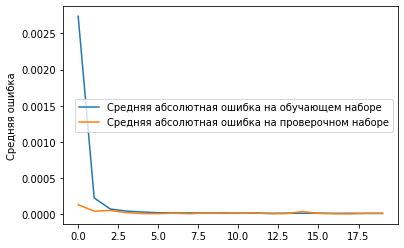

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#modelD.save('/content/drive/My Drive/AIFramework/time_series/model_share.h5')
#modelD.save_weights('/content/drive/My Drive/AIFramework/time_series/model_share_w.h5')
np.save('/content/drive/My Drive/AIFramework/time_series/loss_shares', history.history['loss'])
np.save('/content/drive/My Drive/AIFramework/time_series/val_loss_shares', history.history['val_loss'])

## Визуализация результатов

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


NameError: ignored

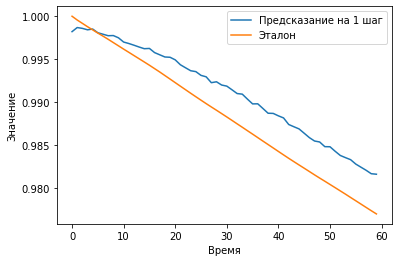

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

## Одномерная свёртка

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=4950

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
22579/22579 [==============================] - 71s 3ms/step - loss: 0.0152 - val_loss: 2.8959e-05
Epoch 2/20
22579/22579 [==============================] - 71s 3ms/step - loss: 0.0019 - val_loss: 1.5758e-04
Epoch 3/20
22579/22579 [==============================] - 70s 3ms/step - loss: 4.7695e-04 - val_loss: 2.1415e-05
Epoch 4/20
22579/22579 [==============================] - 72s 3ms/step - loss: 1.6692e-04 - val_loss: 1.3241e-05
Epoch 5/20
22579/22579 [==============================] - 71s 3ms/step - loss: 7.8694e-05 - val_loss: 1.2063e-04
Epoch 6/20
22579/22579 [==============================] - 71s 3ms/step - loss: 6.7748e-05 - val_loss: 7.9486e-06
Epoch 7/20
22579/22579 [==============================] - 71s 3ms/step - loss: 4.0755e-05 - val_loss: 3.4147e-06
Epoch 8/20
22579/22579 [==============================] - 71s 3ms/step - loss: 3.0698e-05 - val_loss: 1.0551e-04
Epoch 9/20
22579/22579 [====

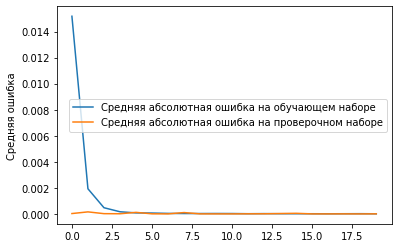

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen,5), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()



In [ ]:
modelC.save('/content/drive/My Drive/AIFramework/time_series/model_share.h5')
modelC.save_weights('/content/drive/My Drive/AIFramework/time_series/model_share_w.h5')
np.save('/content/drive/My Drive/AIFramework/time_series/loss_shares', history.history['loss'])
np.save('/content/drive/My Drive/AIFramework/time_series/val_loss_shares', history.history['val_loss'])

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

In [ ]:
np.save('/content/drive/My Drive/AIFramework/time_series/predVal', predVal)
np.save('/content/drive/My Drive/AIFramework/time_series/yValUnscaled', yValUnscaled)

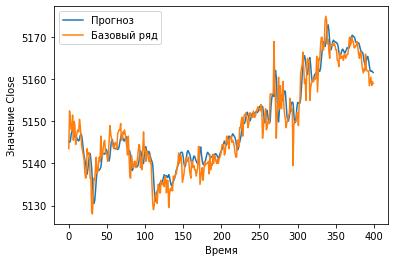

In [ ]:
#Отображаем графики
showPredict(300, 400, 0, predVal-5, yValUnscaled)

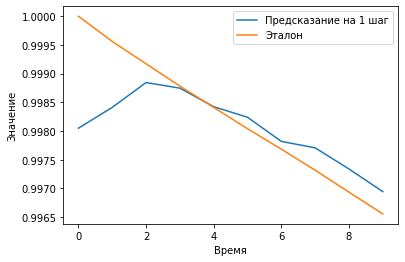

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## LSTM

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
22579/22579 [==============================] - 371s 16ms/step - loss: 0.0157 - val_loss: 2.0684e-05
Epoch 2/10
22579/22579 [==============================] - 373s 17ms/step - loss: 3.8529e-05 - val_loss: 3.3516e-06
Epoch 3/10
22579/22579 [==============================] - 381s 17ms/step - loss: 7.1197e-06 - val_loss: 8.9598e-06
Epoch 4/10
22579/22579 [==============================] - 380s 17ms/step - loss: 2.3636e-06 - val_loss: 3.1176e-06
Epoch 5/10
22579/22579 [==============================] - 370s 16ms/step - loss: 2.1214e-06 - val_loss: 2.8961e-06
Epoch 6/10
22579/22579 [==============================] - 383s 17ms/step - loss: 1.9670e-06 - val_loss: 2.7049e-06
Epoch 7/10
22579/22579 [==============================] - 369s 16ms/step - loss: 1.8346e-06 - val_loss: 1.7682e-06
Epoch 8/10
22579/22579 [==============================] - 385s 17ms/step - loss: 1.7365e-06 - val_loss: 2.1713e-06
Epoch 9/

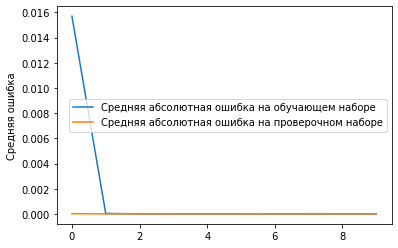

In [ ]:
import tensorflow
modelL = Sequential()
modelL.add(LSTM(5, input_shape = (xLen, 5)))
modelL.add(Dense(10, activation="linear"))
modelL.add(Dense(1, activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelL.fit_generator(trainDataGen, 
                    epochs=10, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelL
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

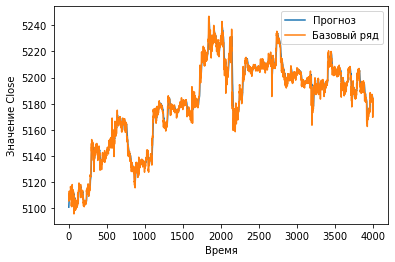

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

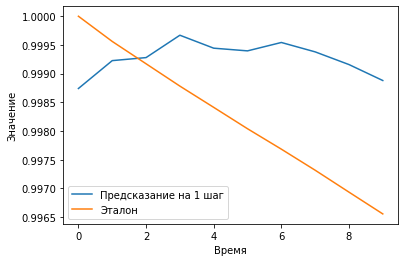

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## ModelX

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=5090

**Сложная сеть из LSTM и Conv1D слоёв на старте и Dense слоёв в конце**

Epoch 1/6
22579/22579 [==============================] - 985s 44ms/step - loss: 9.7152e-04 - val_loss: 4.5019e-05
Epoch 2/6
22579/22579 [==============================] - 974s 43ms/step - loss: 7.2238e-05 - val_loss: 4.5330e-05
Epoch 3/6
22579/22579 [==============================] - 965s 43ms/step - loss: 4.1237e-05 - val_loss: 1.5301e-05
Epoch 4/6
22579/22579 [==============================] - 962s 43ms/step - loss: 2.9914e-05 - val_loss: 1.3877e-04
Epoch 5/6
22579/22579 [==============================] - 960s 43ms/step - loss: 2.3818e-05 - val_loss: 5.7628e-06
Epoch 6/6
22579/22579 [==============================] - 963s 43ms/step - loss: 2.0044e-05 - val_loss: 5.8348e-06


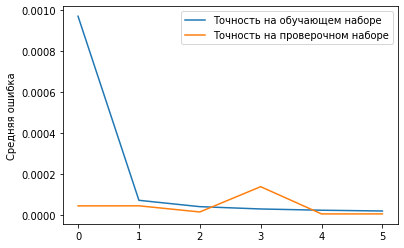

In [ ]:
dataInput = Input(shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]))

lstmWay = LSTM(20, return_sequences="True")(dataInput)
convWay = Conv1D(20, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(20, 5, activation="relu")(lstmWay)
convLstmWay = LSTM(20, return_sequences="True")(convWay)

lstmWay = LSTM(20, return_sequences="True")(lstmWay)
convWay = Conv1D(20, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

modelX.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelX.fit_generator(trainDataGen, 
                    epochs=6, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

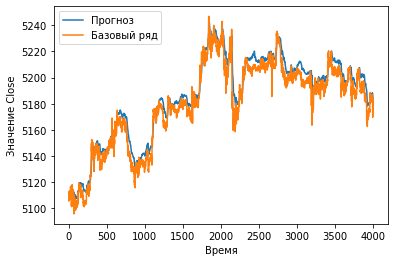

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

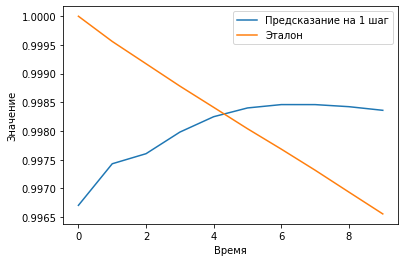

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

# Прогнозирование цены бензина

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=5311

In [ ]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import load_model

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Считываем данные с помощью pandas
#Для чтения tsv файла ставим sep='\t'
base_data = pd.read_csv('/content/drive/My Drive/Базы/petrol_price_2004-2019.tsv', sep='\t')

In [ ]:
print(base_data.iloc[:,9:12].head(20))

    DESVIO PADRÃO REVENDA  PREÇO MÍNIMO REVENDA  PREÇO MÁXIMO REVENDA
0                   0.016                 1.190                 1.350
1                   0.114                 0.890                 1.449
2                   0.097                 1.180                 1.760
3                   0.070                 1.090                 1.509
4                   0.078                 1.050                 1.400
5                   0.132                 0.999                 2.050
6                   0.218                 1.030                 1.950
7                   0.158                 1.350                 2.000
8                   0.130                 1.100                 1.699
9                   0.141                 0.989                 1.700
10                  0.134                 1.400                 1.780
11                  0.116                 1.090                 1.590
12                  0.109                 1.150                 1.750
13                  

In [ ]:
#Группируем данные по неделе старта
#В исходных данных по каждой неделе данные по нескольким регионам страны
data2 = base_data.groupby('DATA INICIAL').mean()

#Оставляем колонки с 3 по 7
#В них нужные для нас числовые данные
data = data2.values[:,2:-1]
print(data.shape)

(785, 6)


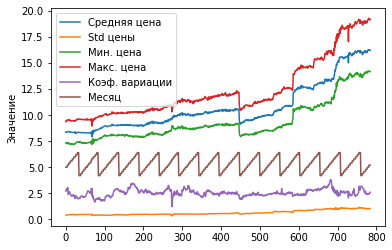

In [ ]:
#Отображаем исходные от точки start и длинной step
start = 0
step = 785

#Подбираем смещения, чтобы удобно расположить графики на экране
koef = [1, 1, 1, 1, 100, 0.2]
bias = [0, 0, 0, 0, -2, 4]

#Заполняем текстовые названия каналов данных
chanelNames = ['Средняя цена', 'Std цены', 'Мин. цена', 'Макс. цена', 'Коэф. вариации', 'Месяц']

#Рисуем все графики данных
for i in range(data.shape[1]):
  plt.plot(koef[i]*data[start:start+step,i] + bias[i], 
          label=chanelNames[i])
plt.ylabel('Значение')
plt.legend()
plt.show()

**Функция загрузки данных**

In [ ]:
#Формируем параметры загрузки данных

xLen = 20    #Анализируем по 20 прошедшим точкам 
valLen = 100 #Используем 100 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,0],(-1,1)), np.reshape(data[trainLen:,0],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=20, sampling_rate=1,   #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=20, sampling_rate=1,
                               batch_size=20)


In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 20, 6) (20, 1)


## Полносвязная сеть

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=5450

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0674 - val_loss: 0.0803
Epoch 2/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0388
Epoch 3/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0115
Epoch 4/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0060
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 10/200
34/34 [=============

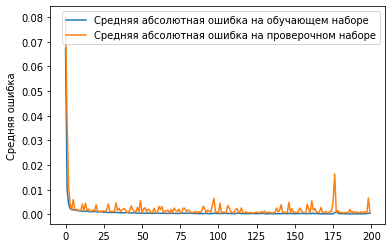

In [ ]:
modelD = Sequential()

modelD.add(Dense(100, input_shape = (xLen,6), activation="relu"))
modelD.add(Dense(100, activation="relu"))
modelD.add(Dense(100, activation="linear"))
modelD.add(Flatten())
modelD.add(Dense(yTrain.shape[1], activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=200, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )


plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Визуализация результатов

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

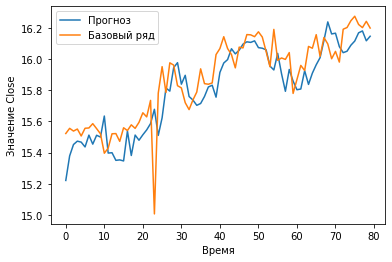

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

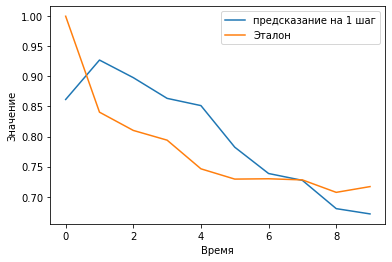

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## Одномерная свёртка

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=5561

Epoch 1/200
34/34 [==============================] - 0s 6ms/step - loss: 0.1354 - val_loss: 0.0094
Epoch 2/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0100 - val_loss: 0.0101
Epoch 3/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0072
Epoch 4/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0080
Epoch 5/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0082
Epoch 6/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0077
Epoch 7/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 8/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 9/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0051
Epoch 10/200
34/34 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 11/

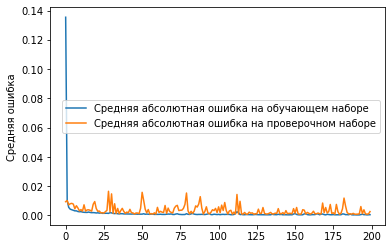

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(50, 10, padding="same", input_shape = (xLen, 6), activation="linear"))
modelC.add(Conv1D(100, 10, padding="same", activation="linear"))
modelC.add(Conv1D(100, 10, padding="same", activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(10, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelC.fit_generator(
                    trainDataGen, 
                    epochs=200, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

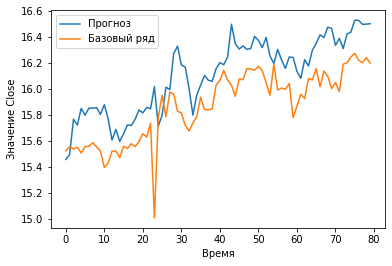

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

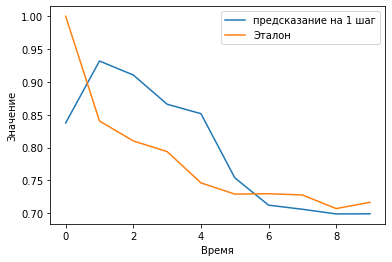

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## LSTM

Epoch 1/100
34/34 [==============================] - 1s 29ms/step - loss: 0.1975 - val_loss: 1.6607
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 0.1151 - val_loss: 1.1842
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0572 - val_loss: 0.7789
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0302 - val_loss: 0.4952
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0209 - val_loss: 0.3465
Epoch 6/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0181 - val_loss: 0.2663
Epoch 7/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.2240
Epoch 8/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.1880
Epoch 9/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.1490
Epoch 10/100
34/34 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.1285
Epoch 11

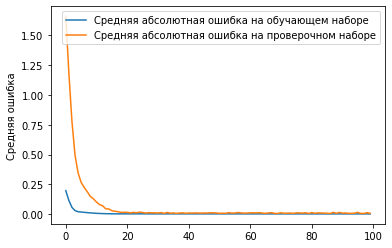

In [ ]:
modelL = Sequential()
modelL.add(LSTM(100, input_shape = (trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]), return_sequences="True"))
modelL.add(LSTM(100, return_sequences="True"))
modelL.add(LSTM(100, return_sequences="True"))
modelL.add(Flatten())
modelL.add(Dense(100, activation="linear"))
modelL.add(Dense(yTrain.shape[1], activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelL.fit_generator(trainDataGen, 
                    epochs=100, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelL
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

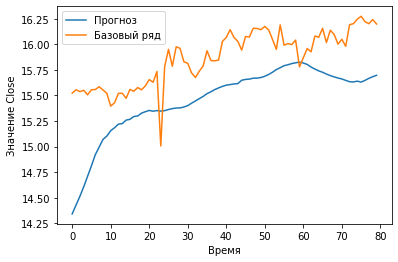

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

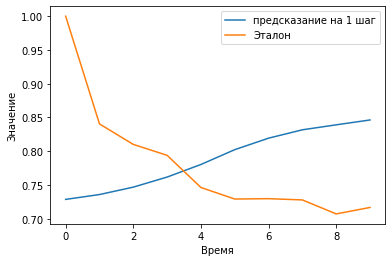

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## ModelX

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=5732

Сложная сеть из LSTM и Conv1D слоёв на старте и Dense слоёв в конце

Epoch 1/60
34/34 [==============================] - 1s 31ms/step - loss: 0.0903 - val_loss: 0.1461
Epoch 2/60
34/34 [==============================] - 0s 9ms/step - loss: 0.0126 - val_loss: 0.1504
Epoch 3/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0585
Epoch 4/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0515
Epoch 5/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0354
Epoch 6/60
34/34 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0269
Epoch 7/60
34/34 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0209
Epoch 8/60
34/34 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0270
Epoch 9/60
34/34 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0150
Epoch 10/60
34/34 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0194
Epoch 11/60
34/34 

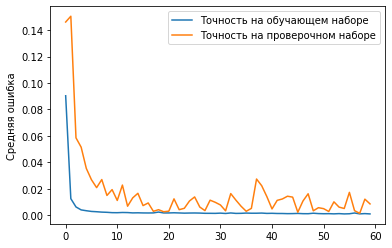

In [ ]:
dataInput = Input(shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]))

lstmWay = LSTM(100, return_sequences="True")(dataInput)
convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(100, 5, activation="relu")(lstmWay)
convLstmWay = LSTM(100, return_sequences="True")(convWay)

lstmWay = LSTM(100, return_sequences="True")(lstmWay)
convWay = Conv1D(100, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(100, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

modelX.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelX.fit_generator(trainDataGen,  
                    epochs=60, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

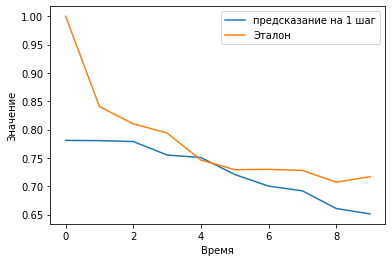

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## Прогнозирование на несколько шагов вперёд

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=5838

In [ ]:
#Формируем параметры загрузки данных
xLen = 20                       #Анализируем по 20 прошедшим точкам 
valLen = 100                    #Используем 100 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,0][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[10][0].shape,
      trainDataGen[10][1].shape)

(20, 20, 6) (20, 10)


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

**Обучаем полносвязную сеть**

Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 0.4909 - val_loss: 0.8836
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0955 - val_loss: 0.1706
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0739 - val_loss: 0.0614
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0647 - val_loss: 0.1054
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0584 - val_loss: 0.0672
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.0588
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.1507
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0623
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0470 - val_loss: 0.3312
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0983
Epoch 11/

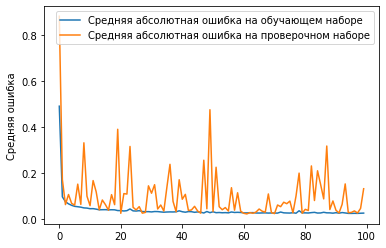

In [ ]:
modelD2 = Sequential()

modelD2.add(Dense(100, input_shape = (xLen,xTrain.shape[1]), activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Flatten())
modelD2.add(Dense(yTrain.shape[1], activation="linear"))

modelD2.compile(loss="mse", optimizer=Adam(lr=1e-4))
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelD2.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/100
33/33 [==============================] - 0s 6ms/step - loss: 0.0240 - val_loss: 0.0238
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0243
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0309
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0217 - val_loss: 0.0330
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0210
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0218 - val_loss: 0.0269
Epoch 7/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0237
Epoch 8/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0216 - val_loss: 0.0252
Epoch 9/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0315
Epoch 10/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0218 - val_loss: 0.0218
Epoch 11/

**Отображаем результаты**

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD2
(predVal2, yValUnscaled2) = getPred(currModel, xVal[0], yVal[0], yScaler)

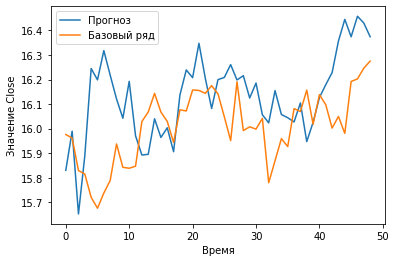

In [ ]:
#Отображаем графики
showPredict(0, 100, 5, predVal2, yValUnscaled2)

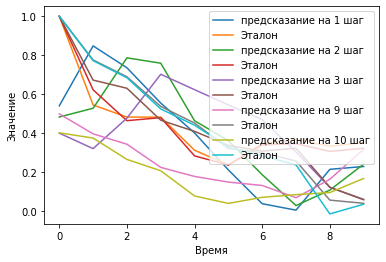

In [ ]:
#Отображаем корреляцию
showCorr([0, 1, 2, 8, 9], 10, predVal2, yValUnscaled2)

## Сложная модель. Предсказание на несколько шагов

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=5983

Epoch 1/40
33/33 [==============================] - 1s 25ms/step - loss: 0.7985 - val_loss: 8.8351
Epoch 2/40
33/33 [==============================] - 0s 7ms/step - loss: 0.3684 - val_loss: 4.4805
Epoch 3/40
33/33 [==============================] - 0s 7ms/step - loss: 0.2349 - val_loss: 2.8834
Epoch 4/40
33/33 [==============================] - 0s 7ms/step - loss: 0.1669 - val_loss: 1.8941
Epoch 5/40
33/33 [==============================] - 0s 7ms/step - loss: 0.1229 - val_loss: 1.0061
Epoch 6/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0955 - val_loss: 0.5632
Epoch 7/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0771 - val_loss: 0.3444
Epoch 8/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0722 - val_loss: 0.2237
Epoch 9/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0644 - val_loss: 0.2061
Epoch 10/40
33/33 [==============================] - 0s 7ms/step - loss: 0.0609 - val_loss: 0.1902
Epoch 11/40
33/33 

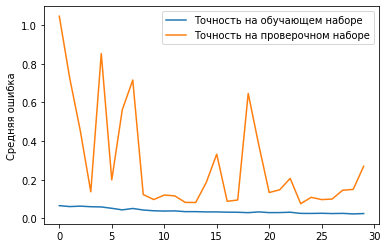

In [ ]:
dataInput = Input(shape=(xLen,6))

lstmWay = LSTM(40, return_sequences="True")(dataInput)
lstmWay = Dropout(0.3)(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmWay = LSTM(40, return_sequences="True")(lstmWay)
lstmWay = Dropout(0.3)(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(convWay)

denseWay = Dense(10, activation="linear")(dataInput)
denseWay = Dense(10, activation="linear")(denseWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
denseWay = Flatten()(denseWay)

finWay = concatenate([lstmWay, convWay, denseWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX3 = Model(dataInput, finWay)

modelX3.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelX3.fit_generator(
                    trainDataGen, 
                    epochs=40, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'][10:], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelX3.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelX3.fit_generator(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/50
33/33 [==============================] - 1s 24ms/step - loss: 0.0222 - val_loss: 0.1253
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0214 - val_loss: 0.1317
Epoch 3/50
33/33 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.1467
Epoch 4/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.1200
Epoch 5/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.1429
Epoch 6/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0216 - val_loss: 0.1033
Epoch 7/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0211 - val_loss: 0.1333
Epoch 8/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0208 - val_loss: 0.1242
Epoch 9/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0210 - val_loss: 0.1142
Epoch 10/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.1324
Epoch 11/50
33/33 

**Отображаем реультаты**

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX3
(predVal3, yValUnscaled3) = getPred(currModel, xVal[0], yVal[0], yScaler)

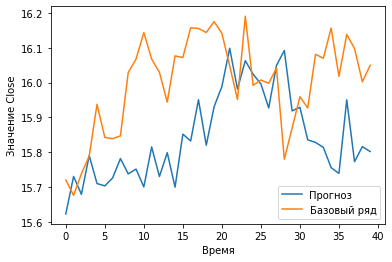

In [ ]:
#Отображаем графики
showPredict(9, 100, 0, predVal3, yValUnscaled3)

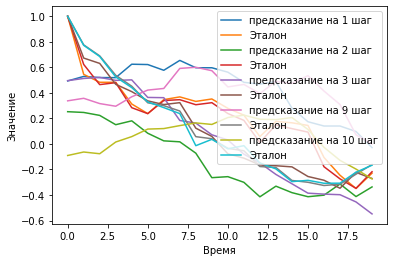

In [ ]:
#Отображаем корреляцию
showCorr([0, 1, 2, 8, 9], 20, predVal3, yValUnscaled3)

## Своя функция ошибки

*Разбор данного раздела:* https://youtu.be/Z_eB3KO_XA4?t=6029

In [ ]:
### Функция ошибки
def getError(x1, x2):
  dx = (x1-x2) ** 2        #Вычислем среднеквадратичную ошибку по точкам
  dxs = np.sort(dx)[::-1]  #Сортируем ошибку в порядке убывания
  return np.mean(dxs[:10]) #Итоговая ошибка равны среднему 10 самых больших ошибок на всём отрезке

In [ ]:
#Вычисляем ошибку при прогнозе на 1 шаг
predictionStep = 0
x1 = predVal2[:,predictionStep]
x2 = yValUnscaled2[:,predictionStep]

print(getError(x1, x2))

In [ ]:
#Отображаем ошибку при прогнозе на несколько шагов вперёд
for i in range(stepsForward):
  x1 = predVal2[:,i]
  x2 = yValUnscaled2[:,i]

  print("Шаг", i+1, "ошибка", round(getError(x1, x2),3))

Шаг 1 ошибка 0.126
Шаг 2 ошибка 0.159
Шаг 3 ошибка 0.128
Шаг 4 ошибка 0.137
Шаг 5 ошибка 0.136
Шаг 6 ошибка 0.175
Шаг 7 ошибка 0.065
Шаг 8 ошибка 0.071
Шаг 9 ошибка 0.064
Шаг 10 ошибка 0.092


In [ ]:
### Функция ошибки

def getError2(x1, x2):
  corr = []
  yLen = x1.shape[0]

  #Вычисляем корреляцию выхода сети в верным ответом
  #Смещая выход сети назад от 0 до 9 шагов
  for i in range(10):
    corr.append(correlate(x1[:yLen-i], x2[i:]))
  
  corr = np.array(corr)
  
  #Возвращаем функцию ошибки, как произведение
  #1 - корреляции без смещения (со смещением на 0)
  #2 - того, во сколько раз корреляция без смещения больше, чем средняя корреляция при смещении на 1-5 шагов
  return corr[0] * (corr[0] / np.max(corr[1:10]))

In [ ]:
#Вычисляем ошибку при прогнозе на 1 шаг
predictionStep = 0
x1 = predVal2[:,predictionStep]
x2 = yValUnscaled2[:,predictionStep]

print(getError2(x1, x2))

0.6014760292441267


In [ ]:
#Отображаем ошибку при прогнозе на несколько шагов вперёд
for i in range(stepsForward):
  x1 = predVal2[:,i]
  x2 = yValUnscaled2[:,i]

  print(round(getError2(x1, x2),4))

0.6015
0.5915
0.5283
0.2028
0.238
0.1984
0.4194
0.4643
0.5113
0.4401


In [ ]:
#Сравнимаем две модели по новой функции ошибки
#При предсказании на несколько шагов вперёд
model1 = modelX3
model2 = modelD2

#Получаем предсказания от обеих сетей
predValM1 = yScaler.inverse_transform(model1.predict(xVal[0]))
predValM2 = yScaler.inverse_transform(model2.predict(xVal[0]))
yValUnscaled3 = yScaler.inverse_transform(yVal)

#Здаём собственную функцию ошибки
errorFunc = getError2

for i in range(stepsForward):
  x1 = predValM1[:,i]
  x2 = predValM2[:,i]
  x = yValUnscaled2[:,i]

  print("Предсказание на", i+1, "шагов: M1 =", round(errorFunc(x1, x),3), "M2 =", round(errorFunc(x2, x),3))

Предсказание на 1 шагов: M1 = 0.618 M2 = 0.601
Предсказание на 2 шагов: M1 = 0.51 M2 = 0.591
Предсказание на 3 шагов: M1 = 0.58 M2 = 0.528
Предсказание на 4 шагов: M1 = -0.05 M2 = 0.203
Предсказание на 5 шагов: M1 = 0.234 M2 = 0.238
Предсказание на 6 шагов: M1 = 0.297 M2 = 0.198
Предсказание на 7 шагов: M1 = 0.206 M2 = 0.419
Предсказание на 8 шагов: M1 = 0.333 M2 = 0.464
Предсказание на 9 шагов: M1 = 0.327 M2 = 0.511
Предсказание на 10 шагов: M1 = -0.069 M2 = 0.44
